In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
from sklearn import preprocessing
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, classification_report
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import catboost as cb

In [2]:
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
df.shape

(145460, 23)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Text(0.5, 1.0, 'type of our data ')

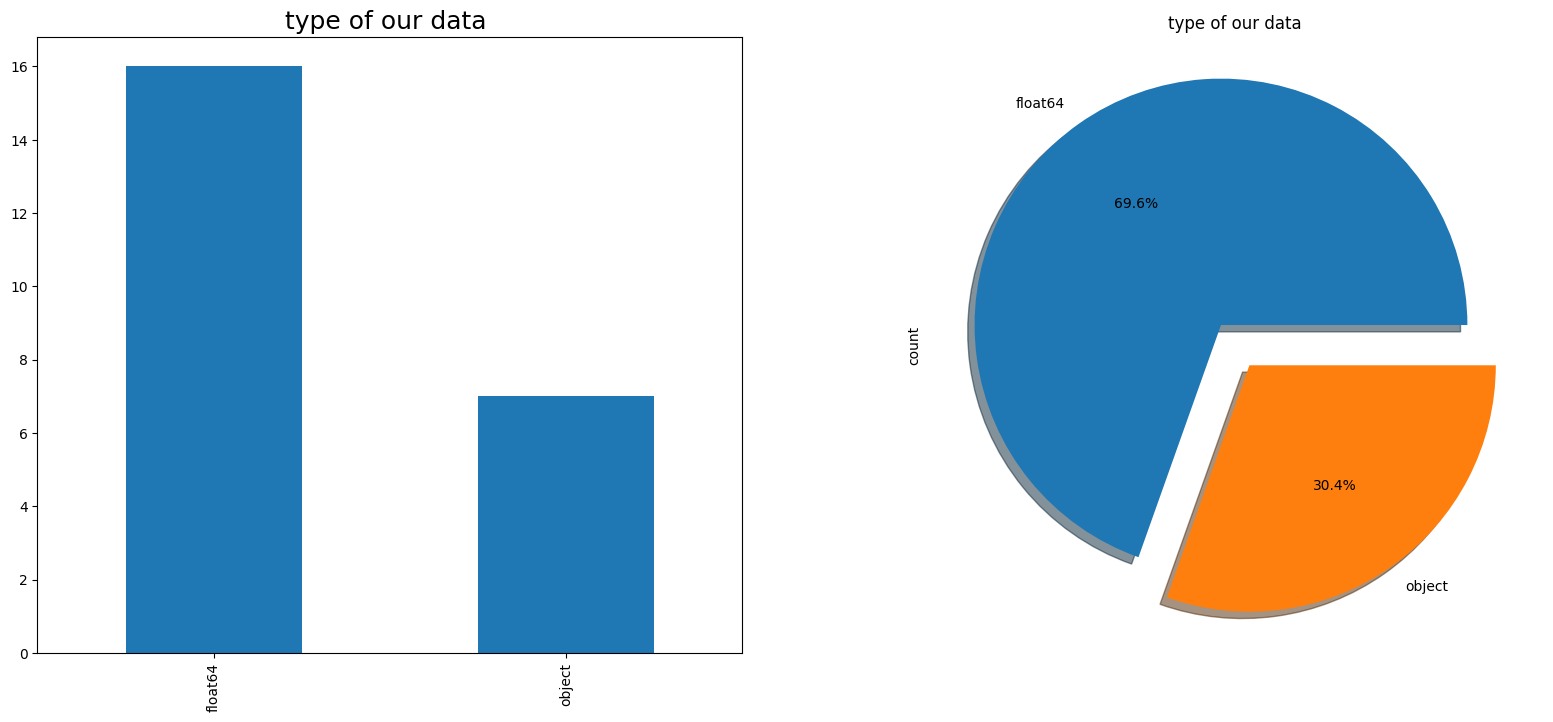

In [5]:
fig, axarr = plt.subplots(1, 2, figsize=(20, 8))

df.dtypes.value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,ax=axarr[1])
axarr[1].set_title("type of our data ", fontsize=18)

df.dtypes.value_counts().plot(kind='bar',ax=axarr[0])
plt.title('type of our data');
axarr[0].set_title("type of our data ", fontsize=18)

In [6]:
df['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

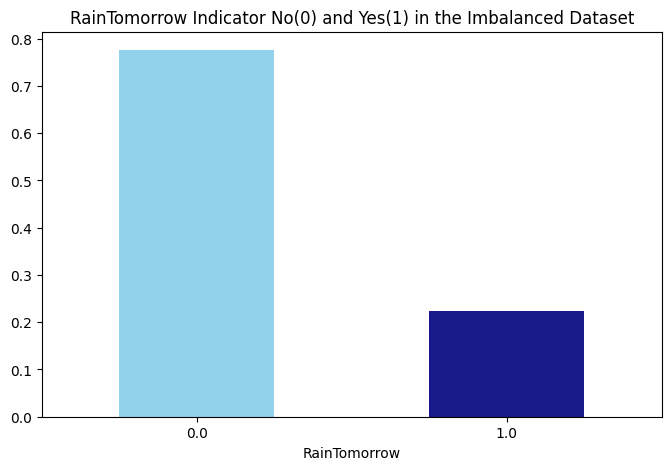

In [7]:
fig = plt.figure(figsize = (8,5))
df.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

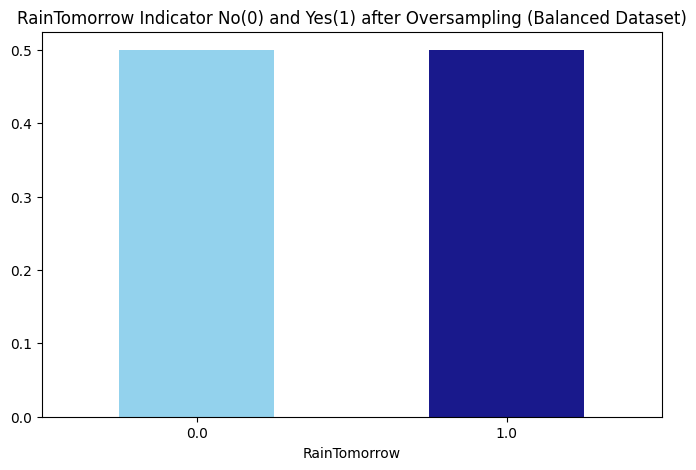

In [8]:
no = df[df.RainTomorrow == 0]
yes = df[df.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

In [9]:
# create a table with data missing
missing_values=df.isnull().sum() # missing values

percent_missing = df.isnull().sum()/df.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing ,
     'data type' : df.dtypes
}
frame=pd.DataFrame(value)
frame

,missing_values,percent_missing %,data type
Date,0,0.000000,object
Location,0,0.000000,object
MinTemp,1485,1.020899,float64
MaxTemp,1261,0.866905,float64
Rainfall,3261,2.241853,float64
Evaporation,62790,43.166506,float64
Sunshine,69835,48.009762,float64
WindGustDir,10326,7.098859,object
WindGustSpeed,10263,7.055548,float64
WindDir9am,10566,7.263853,object


<Axes: >

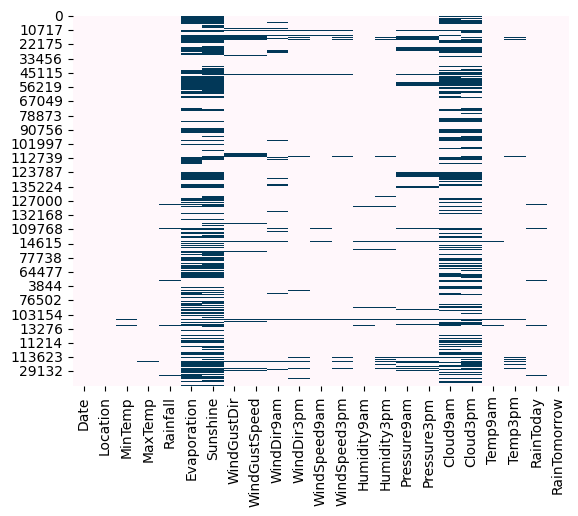

In [10]:
# Missing Data Pattern in Training Data

sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

In [11]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


In [12]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [13]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [14]:
# Convert categorical features to continuous features with Label Encoding
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [15]:
# Multiple Imputation by Chained Equations
MiceImputed = oversampled.copy(deep=True)
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [16]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.3)
Q3 = MiceImputed.quantile(0.7)
IQR = Q3 - Q1
print(IQR)

Date             1229.000000
Location           20.000000
MinTemp             7.200000
MaxTemp             8.000000
Rainfall            1.400000
Evaporation         3.200000
Sunshine            4.710692
WindGustDir         7.000000
WindGustSpeed      15.000000
WindDir9am          7.000000
WindDir3pm          6.000000
WindSpeed9am       10.000000
WindSpeed3pm       11.000000
Humidity9am        20.000000
Humidity3pm        24.000000
Pressure9am         6.700000
Pressure3pm         6.700000
Cloud9am            3.396484
Cloud3pm            3.000000
Temp9am             7.300000
Temp3pm             7.700000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [17]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(138304, 23)

In [18]:
# Standardizing data
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [19]:
# Feature Importance using Filter Method (Chi-Square)

X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp3pm',
       'RainToday'],
      dtype='object')


In [20]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir',
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=12345)

# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [21]:
def plot_roc_cur(fper, tper):
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [22]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))

    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    plot_roc_cur(fper, tper)

    cm = confusion_matrix(y_test, y_pred)  # Normalisasi matriks kebingungan
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='.2f')  # Menggunakan '.2f' untuk format nilai
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig('static/confusion_matrix.png')
    plt.show()

    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.9422298274366143
ROC Area under Curve = 0.9453245631038409
Cohen's Kappa = 0.8831165389746594
Time taken = 350.2086868286133
              precision    recall  f1-score   support

         0.0    0.97402   0.92336   0.94801     23669
         1.0    0.90480   0.96729   0.93500     17823

    accuracy                        0.94223     41492
   macro avg    0.93941   0.94532   0.94151     41492
weighted avg    0.94428   0.94223   0.94242     41492



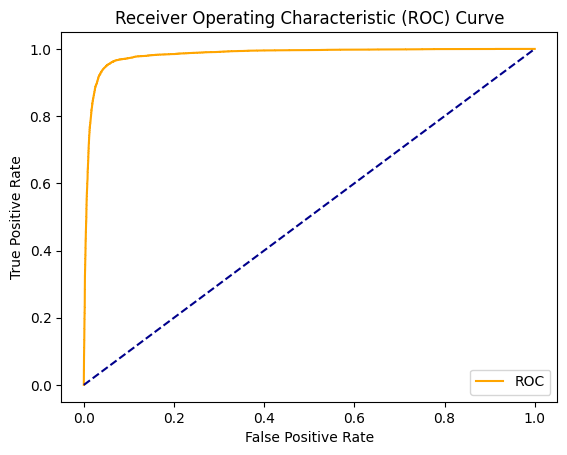

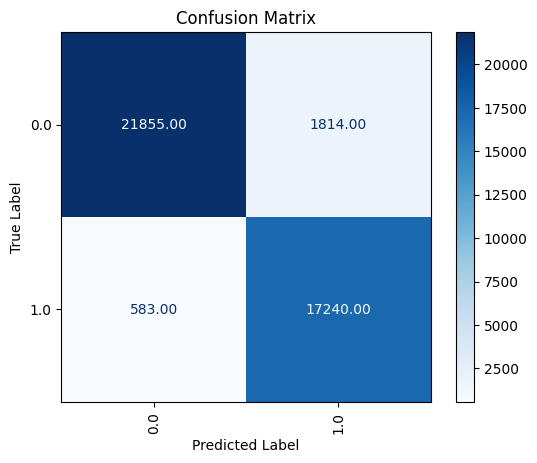

In [23]:
# Catboost
params_cb ={'iterations': 50,
            'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)

In [24]:
# import pickle
# pickle.dump(model_cb, open("model.pkl", "wb"))